In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [10]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [11]:
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_train.csv')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_train.csv')

train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_train.csv')
#don't touch test data, split out validation data from training data during training
test_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_test.csv')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_test.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_test.csv')

In [12]:
from sklearn.preprocessing import StandardScaler
def normalize_dataframe(df):
    """
    Normalize the given DataFrame column-wise while keeping NaN values unchanged.

    :param df: Pandas DataFrame to be normalized.
    :return: Normalized DataFrame.
    """
    scaler = StandardScaler()
    for column in df.columns:
        # Extract the non-NaN values and their indices
        non_nan_values = df[column].dropna()
        indices = non_nan_values.index
        
        # Normalize the non-NaN values
        normalized_values = scaler.fit_transform(non_nan_values.values.reshape(-1, 1)).flatten()
        
        # Assign the normalized values back to the DataFrame
        df.loc[indices, column] = normalized_values
    
    return df

# train_target = normalize_dataframe(train_target)


In [13]:
N_samples = train_data.shape[0]
DRUGS = ['AMIKACIN',
 'CAPREOMYCIN',
 'CIPROFLOXACIN',
 'ETHAMBUTOL',
 'ETHIONAMIDE',
 'ISONIAZID',
 'KANAMYCIN',
 'LEVOFLOXACIN',
 'MOXIFLOXACIN',
 'OFLOXACIN',
 'PYRAZINAMIDE',
 'RIFAMPICIN',
 'STREPTOMYCIN']

DRUGS = train_target.columns
LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [14]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

# Dateset

In [15]:
class OneHotSeqsDataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        self.seq_df = seq_df[target_loci]
        self.res_df = res_df[target_drugs]
        if not self.seq_df.index.equals(self.res_df.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df.iloc[index].str.cat()
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df.loc[index].str.cat()
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_df.shape[0]

training_dataset = OneHotSeqsDataset(train_data, train_target, one_hot_dtype=torch.float, transform=True)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

In [16]:
for x, y in train_dataset:
    print(x)
    print(y)
    break

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([-2.0794, -4.1997, -4.1997, -5.5215,  0.0000,  0.0000, -2.9957, -0.6931,
        -1.3863, -2.1203, -2.1203, -4.1997, -3.5066], dtype=torch.float64)


# Model

In [17]:
in_channels=4
num_classes=1
num_filters=64
filter_length=25
num_conv_layers=2
filter_scaling_factor=1.5  # New parameter
num_dense_neurons=256
num_dense_layers=4
conv_dropout_rate=0.0
dense_dropout_rate=0.2
return_logits=False
[num_filters]+ [num_dense_neurons] * (num_dense_layers - 1)

[64, 256, 256, 256]

In [18]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)



epoch = 250
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [12]:
# for x, y in train_loader:
#     x_train = x
#     y_train = y
#     break

# for x, y in test_loader:
#     x_test = x
#     y_test = y
#     break

# Training

### Training test - lost function

In [140]:
def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        # print(y_pred)
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # y_pred = y_pred.view(13, -1)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # print(y_pred.shape)
        # print(y_pred)
        # print(y_true)
        # ic(y_pred.shape)
        # ic(y_true.shape)
        print(y_true)
        print(y_true.isnan())
        non_nan_mask = ~y_true.isnan()
        print(non_nan_mask)
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]
        print(y_pred_non_nan)
        print(y_true_non_nan)
        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE1 = get_masked_loss(torch.nn.MSELoss())
criterion1 = masked_MSE1

In [141]:
import torch

# Example scalar tensor with NaN
y_true = torch.tensor(float('nan'), dtype=torch.float64)
y_true = y_train[6,2]
# Check if there are any NaN values
isnan = torch.isnan(y_true)
print(isnan)  # This should print 'True' for a NaN value


tensor(False)


In [120]:
y_train[6,2].isnan()

tensor(True)

In [121]:
y_train.isnan()

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False,  True, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False]])

In [152]:
np.log2(y_batch.cpu().numpy()+1)

array([[0.169925  , 0.01077991, 0.0426443 , 0.01077991, 0.5849625 ,
        1.        , 0.01613973, 1.5849625 , 0.32192808, 0.32192808,
        0.16349874, 0.0426443 , 0.0426443 ],
       [0.5849625 , 0.0426443 , 0.5849625 , 0.08406419, 3.169925  ,
        3.169925  , 2.0703893 , 1.5849625 , 3.169925  , 0.5849625 ,
        2.321928  , 3.169925  , 2.321928  ],
       [0.169925  , 0.0426443 , 0.32192808, 0.0057592 , 3.169925  ,
        1.5849625 , 2.8875253 , 1.5849625 , 0.32192808, 0.5849625 ,
        0.5849625 , 4.087463  , 2.321928  ],
       [0.5849625 , 0.08406419, 0.16349874, 0.02147971, 1.        ,
        1.        , 0.01613973, 1.5849625 , 0.5849625 , 0.5849625 ,
        0.32192808, 0.16349874, 0.0426443 ],
       [0.169925  , 0.0426443 , 0.0426443 , 0.01077991, 2.321928  ,
        4.087463  , 2.0703893 , 0.5849625 , 0.32192808, 0.32192808,
        0.16349874, 3.169925  , 1.5849625 ],
       [0.169925  , 0.0426443 , 0.0426443 , 0.01077991, 1.5849625 ,
        1.5849625 , 1.37851

In [149]:
y_batch = torch.tensor([[1.2500e-01, 7.5000e-03, 3.0000e-02, 7.5000e-03, 5.0000e-01, 1.0000e+00,
         1.1250e-02, 2.0000e+00, 2.5000e-01, 2.5000e-01, 1.2000e-01, 3.0000e-02,
         3.0000e-02],
        [5.0000e-01, 3.0000e-02, 5.0000e-01, 6.0000e-02, 8.0000e+00, 8.0000e+00,
         3.2000e+00, 2.0000e+00, 8.0000e+00, 5.0000e-01, 4.0000e+00, 8.0000e+00,
         4.0000e+00],
        [1.2500e-01, 3.0000e-02, 2.5000e-01, 4.0000e-03, 8.0000e+00, 2.0000e+00,
         6.4000e+00, 2.0000e+00, 2.5000e-01, 5.0000e-01, 5.0000e-01, 1.6000e+01,
         4.0000e+00],
        [5.0000e-01, 6.0000e-02, 1.2000e-01, 1.5000e-02, 1.0000e+00, 1.0000e+00,
         1.1250e-02, 2.0000e+00, 5.0000e-01, 5.0000e-01, 2.5000e-01, 1.2000e-01,
         3.0000e-02],
        [1.2500e-01, 3.0000e-02, 3.0000e-02, 7.5000e-03, 4.0000e+00, 1.6000e+01,
         3.2000e+00, 5.0000e-01, 2.5000e-01, 2.5000e-01, 1.2000e-01, 8.0000e+00,
         2.0000e+00],
        [1.2500e-01, 3.0000e-02, 3.0000e-02, 7.5000e-03, 2.0000e+00, 2.0000e+00,
         1.6000e+00, 5.0000e-01, 4.0000e+00, 5.0000e-01, 2.0000e+00, 8.0000e+00,
         4.0000e+00],
        [1.2500e-01, 7.5000e-03,        nan, 7.5000e-03, 4.0000e+00, 8.0000e+00,
         1.6000e+00, 5.0000e-01, 6.0000e-02, 1.5000e-01, 3.0000e-02, 4.0000e+00,
         1.0000e+00],
        [1.2500e-01, 6.0000e-02, 1.2000e-01, 7.5000e-03, 4.0000e+00, 5.0000e-01,
         3.2000e+00, 2.0000e+00, 2.0000e+00, 2.5000e-01, 1.0000e+00, 8.0000e+00,
         4.0000e+00]], device='cuda:0')
pred = torch.tensor([[0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000],
        [0.2201, 0.0000, 0.1536, 0.0143, 3.3798, 3.6438, 2.6070, 1.5595, 2.1771,
         0.3605, 0.0000, 3.9017, 0.0000]], device='cuda:0')

### Training

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []



for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)
        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print('y_batch')
        # print(y_batch)
        # print('pred')
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        ic(pred.size())
        loss_train = criterion(y_batch, pred)
        # print('loss_train')
        # print(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
print('==='*10)
torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/model_lr0.00002_2conv_2dense_128neuron_60epoch_reduceonplateau.pt')

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

In [14]:
len(train_epoch_loss)

10800

ValueError: x and y must have same first dimension, but have shapes (80,) and (10800,)

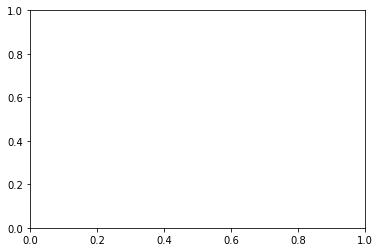

In [12]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

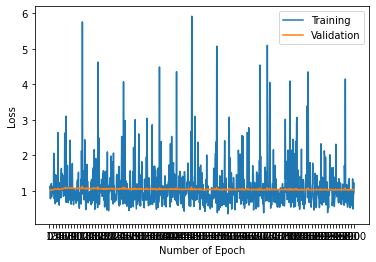

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)

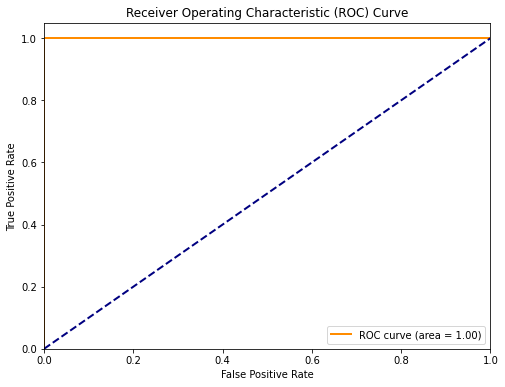

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

143

In [19]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Fri Mar  1 12:37:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |    721MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [20]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=13,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=0,
    dense_dropout_rate=0
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            pred = model(x_batch.float())
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    x = np.arange(1, epoch+1, 1)
    fig, ax = plt.subplots(facecolor = 'white')
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, fc_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')
    save_to_file('trials2.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)
    print(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')

lr: 0.0001 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [5:14:29<00:00, 62.90s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.png
lr: 0.0001 | fc_dr: 0 | cnn_dr: 0 | l2: 1e-09 ==============================


100%|██████████| 300/300 [5:15:05<00:00, 63.02s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.png
lr: 0.0001 | fc_dr: 0 | cnn_dr: 0 | l2: 1e-08 ==============================


100%|██████████| 300/300 [5:10:32<00:00, 62.11s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.png
lr: 0.0001 | fc_dr: 0 | cnn_dr: 0 | l2: 1e-07 ==============================


100%|██████████| 300/300 [5:11:19<00:00, 62.26s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.png
lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [5:09:44<00:00, 61.95s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.2.png
lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-09 ==============================


100%|██████████| 300/300 [5:10:35<00:00, 62.12s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.2.png
lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-08 ==============================


100%|██████████| 300/300 [5:09:37<00:00, 61.93s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.2.png
lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-07 ==============================


100%|██████████| 300/300 [5:09:05<00:00, 61.82s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.2.png
lr: 0.0001 | fc_dr: 0.3 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [5:10:26<00:00, 62.09s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.3.png
lr: 0.0001 | fc_dr: 0.3 | cnn_dr: 0 | l2: 1e-09 ==============================


100%|██████████| 300/300 [5:10:25<00:00, 62.08s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.3.png
lr: 0.0001 | fc_dr: 0.3 | cnn_dr: 0 | l2: 1e-08 ==============================


100%|██████████| 300/300 [5:10:10<00:00, 62.04s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.3.png
lr: 0.0001 | fc_dr: 0.3 | cnn_dr: 0 | l2: 1e-07 ==============================


100%|██████████| 300/300 [5:09:49<00:00, 61.96s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.3.png
lr: 0.0001 | fc_dr: 0.4 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [5:09:52<00:00, 61.98s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.4.png
lr: 0.0001 | fc_dr: 0.4 | cnn_dr: 0 | l2: 1e-09 ==============================


100%|██████████| 300/300 [5:10:20<00:00, 62.07s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.4.png
lr: 0.0001 | fc_dr: 0.4 | cnn_dr: 0 | l2: 1e-08 ==============================


100%|██████████| 300/300 [5:17:33<00:00, 63.51s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.4.png
lr: 0.0001 | fc_dr: 0.4 | cnn_dr: 0 | l2: 1e-07 ==============================


100%|██████████| 300/300 [5:14:58<00:00, 62.99s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.4.png
lr: 0.0001 | fc_dr: 0.5 | cnn_dr: 0 | l2: 0 ==============================


100%|██████████| 300/300 [5:08:47<00:00, 61.76s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.5.png
lr: 0.0001 | fc_dr: 0.5 | cnn_dr: 0 | l2: 1e-09 ==============================


100%|██████████| 300/300 [5:09:12<00:00, 61.84s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.5.png
lr: 0.0001 | fc_dr: 0.5 | cnn_dr: 0 | l2: 1e-08 ==============================


100%|██████████| 300/300 [5:10:37<00:00, 62.12s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.5.png
lr: 0.0001 | fc_dr: 0.5 | cnn_dr: 0 | l2: 1e-07 ==============================


100%|██████████| 300/300 [5:10:33<00:00, 62.11s/it]  
/tmp/ipykernel_110019/1478577944.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs2/64-2-256-2-128-log-reg_loss_lr_0.0001_cnn_dr_0_fc_dr_0.5.png


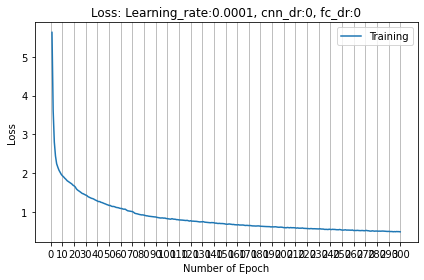

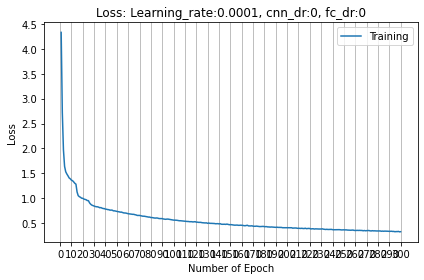

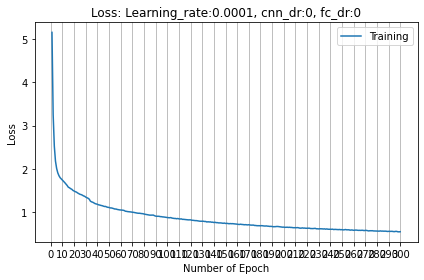

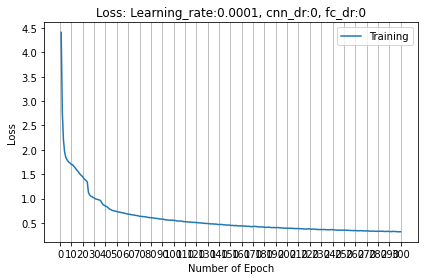

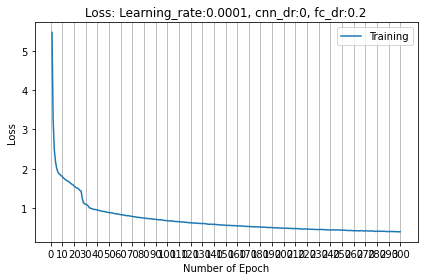

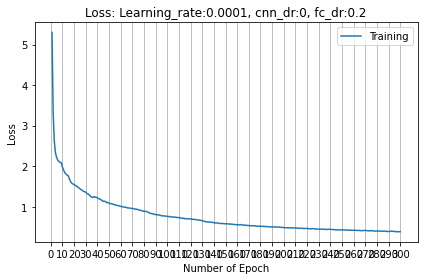

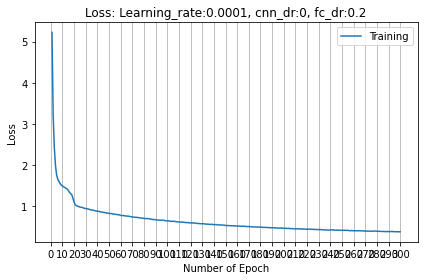

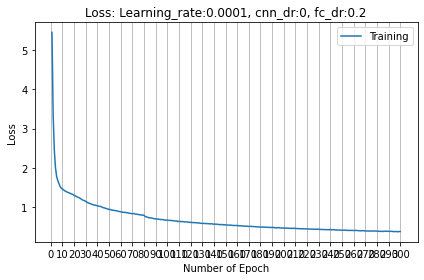

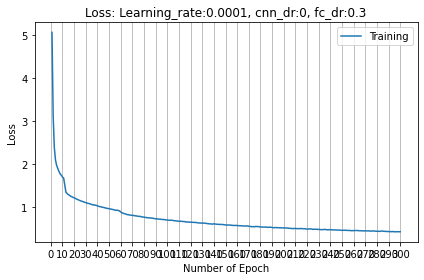

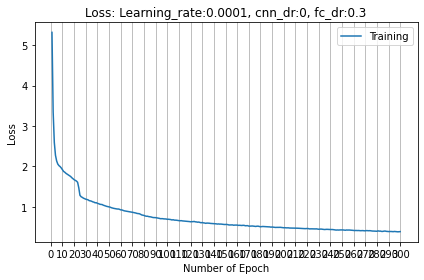

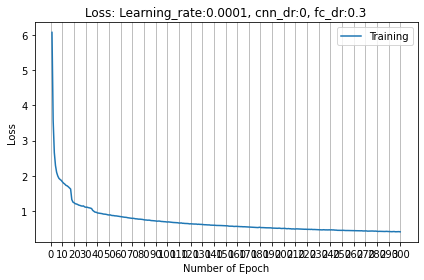

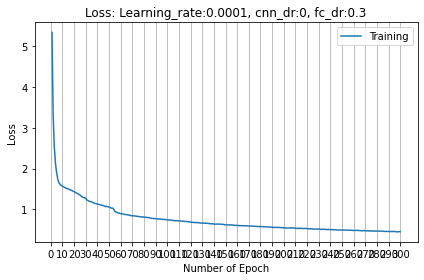

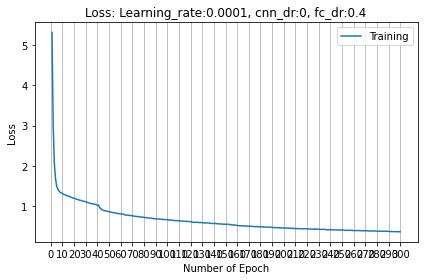

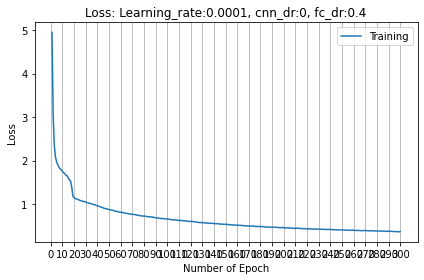

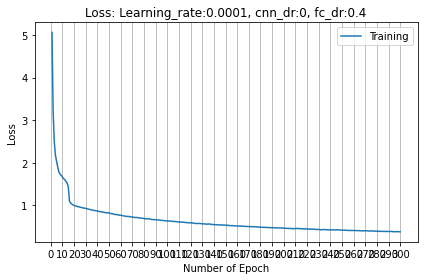

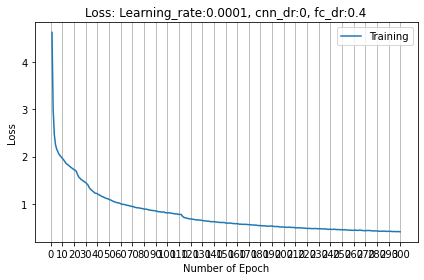

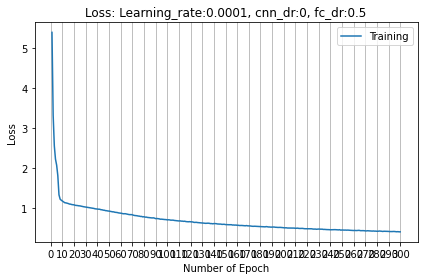

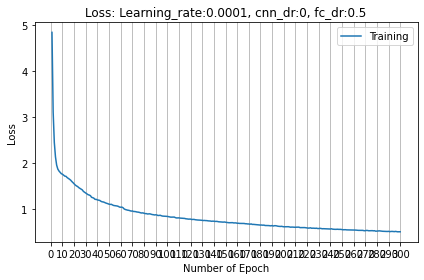

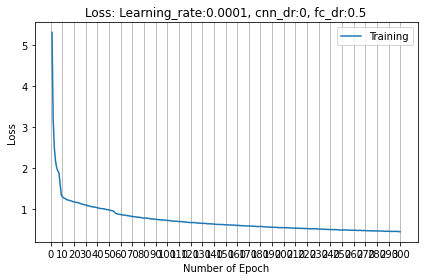

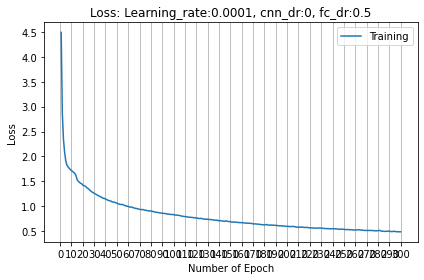

In [22]:
torch.cuda.empty_cache()
import gc; gc.collect()

epoch = 300
for lr in [1e-4]:
    for fc_dr in [0, 0.2, 0.3, 0.4, 0.5]:
        for decay in [0, 1e-9,1e-8, 1e-7]:
            hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, l2=decay, epoch=epoch)


lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


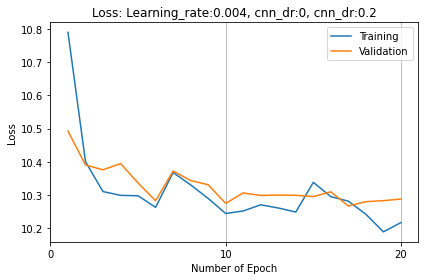

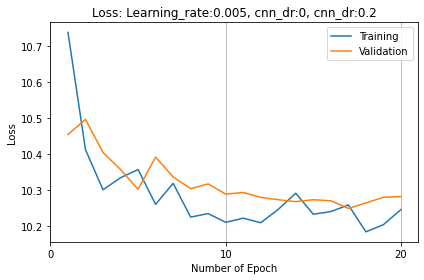

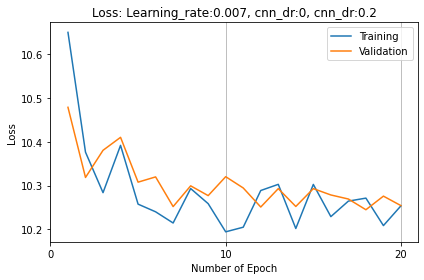

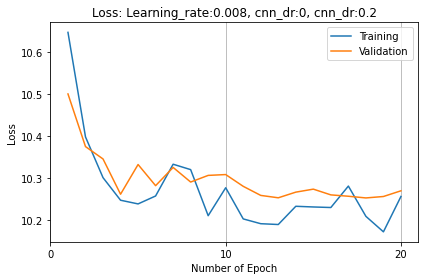

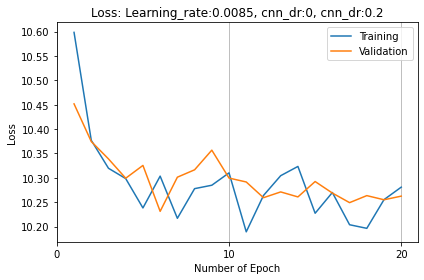

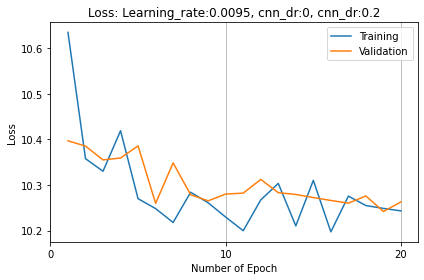

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

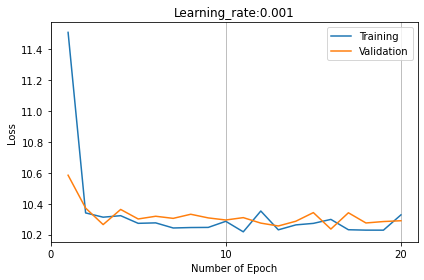

In [ ]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")